# 1. Modules

## 1.1. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

## 1.2. Load library modules

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.misc.load import load_matlab_data
from magrec.transformation.Bxyz2Jxy import Bxyz2Jxy
from magrec.transformation.Bsensor2Jxy import Bsensor2Jxy
from magrec.transformation.MagneticFields import MagneticFields 


from magrec.misc.data import Data
from magrec import __datapath__

# 2. Data

## 2.1. Load Data¶

(55, 125)
(55, 125)
(110, 250)
Applied a high frequency filter, removing all components smaller than 0.1 um


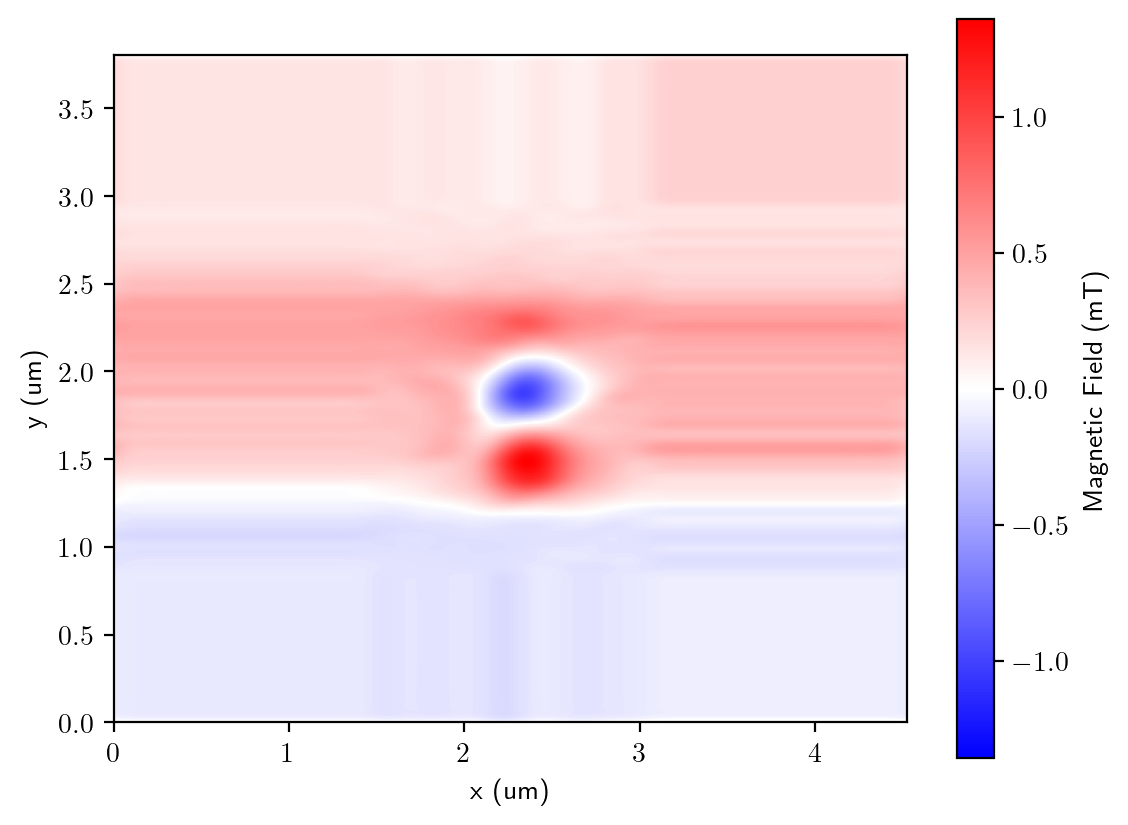

torch.Size([450, 310])


In [101]:
from scipy import interpolate

mat = load_matlab_data(__datapath__ / "experimental" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")
B_NV = mat['Bnv_map']

print(B_NV.shape)

x = np.linspace(0, B_NV.shape[1], B_NV.shape[1])
y = np.linspace(0, B_NV.shape[0], B_NV.shape[0])
xx, yy = np.meshgrid(x, y)

print(xx.shape)

f = interpolate.interp2d(x, y, B_NV, kind='cubic')

xnew =  np.linspace(0, B_NV.shape[1], int(2*B_NV.shape[1]))

ynew =  np.linspace(0, B_NV.shape[0], int(2*B_NV.shape[0]))

B_new = f(xnew, ynew)
print(B_new.shape)

B = B_new * 1e3

B_smoothed = sp.ndimage.gaussian_filter(B, sigma=1)

B_NV = np.pad(B_smoothed,100, mode='edge')

# B_NV = np.concatenate((np.flipud(B), B, np.flipud(B)) )*1e3








sensor_theta = 50
sensor_phi = -145 + 90 

dy = 0.0169 *0.5
dx = 0.0292 * 0.5
height = 0.01
thickness = 0.001

dataset = Data()
dataset.load_data(
       B_NV_smoothed.T, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

# dataset.remove_DC_background()
dataset.add_hanning_filter(0.1)
dataset.add_short_wavelength_filter(0.1)

# dataset.crop_data((1,198,1,198))
# dataset.pad_data_to_power_of_two()
# dataset.pad_reflective2d()
dataset.plot_target()


print(dataset.target.shape)

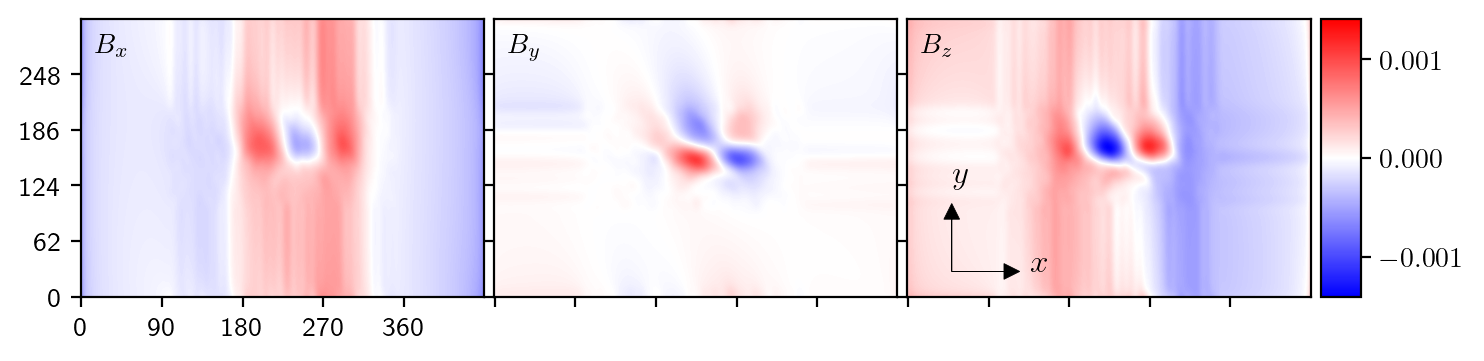

In [102]:
# check the orintation
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

In [103]:
# check the actions that have been applied to the dataset
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.1
2,short_wavelength_filter,False,None,"Applied a high frequency filter, removing all ...",wavelength = 0.1


# Fourier method reconstruction

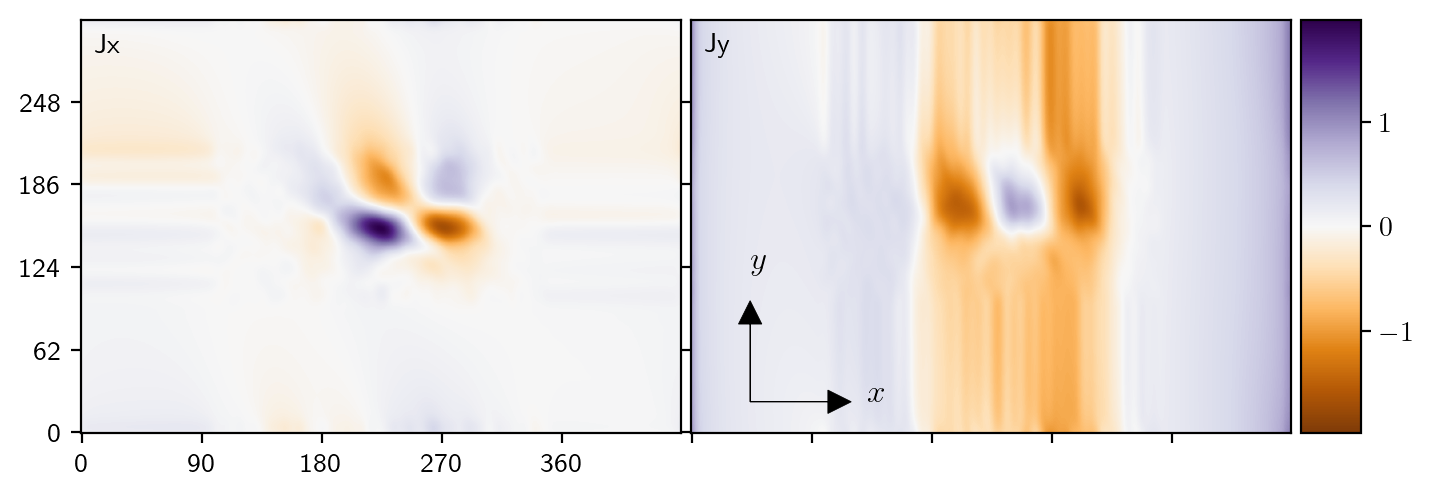

In [104]:
dataset2 = copy.deepcopy(dataset)

dataset2.target = dataset2.transformed_target

dataset2.set_transformer(Bxyz2Jxy)
dataset2.transform_data()


plot_n_components(
    dataset2.transformed_target, 
    symmetric=True, 
    labels=["Jx", "Jy"], 
    cmap="PuOr")


## 3.2 test that the Jxy to Bsensor transform works

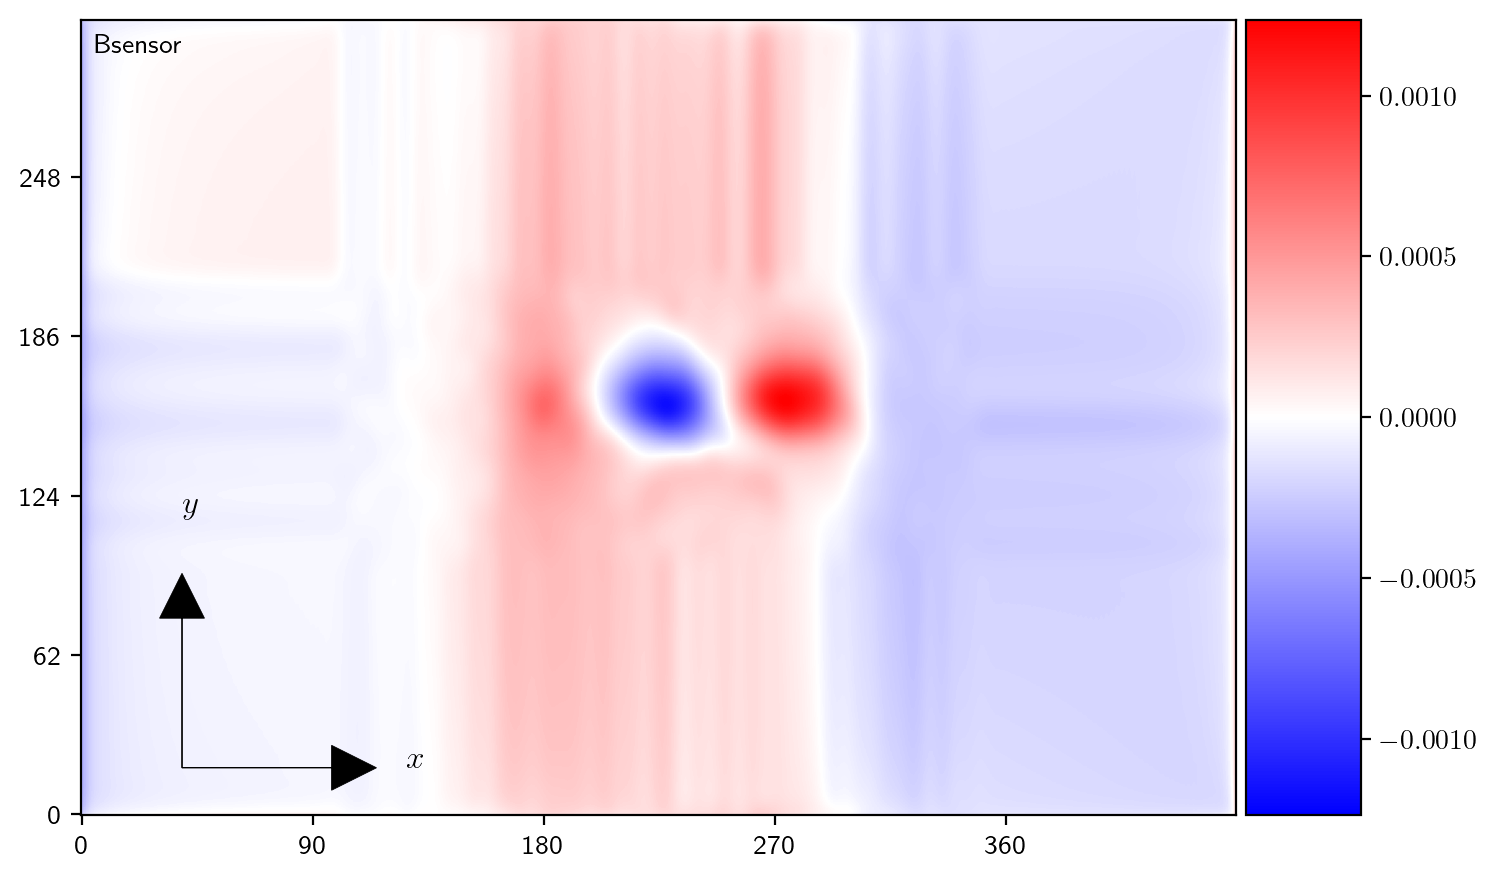

In [105]:
from magrec.transformation.Jxy2Bsensor import Jxy2Bsensor
dataset3 = copy.deepcopy(dataset2)
brecon = Jxy2Bsensor(dataset3)
B_sensor_recon = brecon.transform(dataset3.transformed_target)


plot_n_components(
    B_sensor_recon, 
    symmetric=True, 
    labels=["Bsensor"], 
    cmap="bwr")


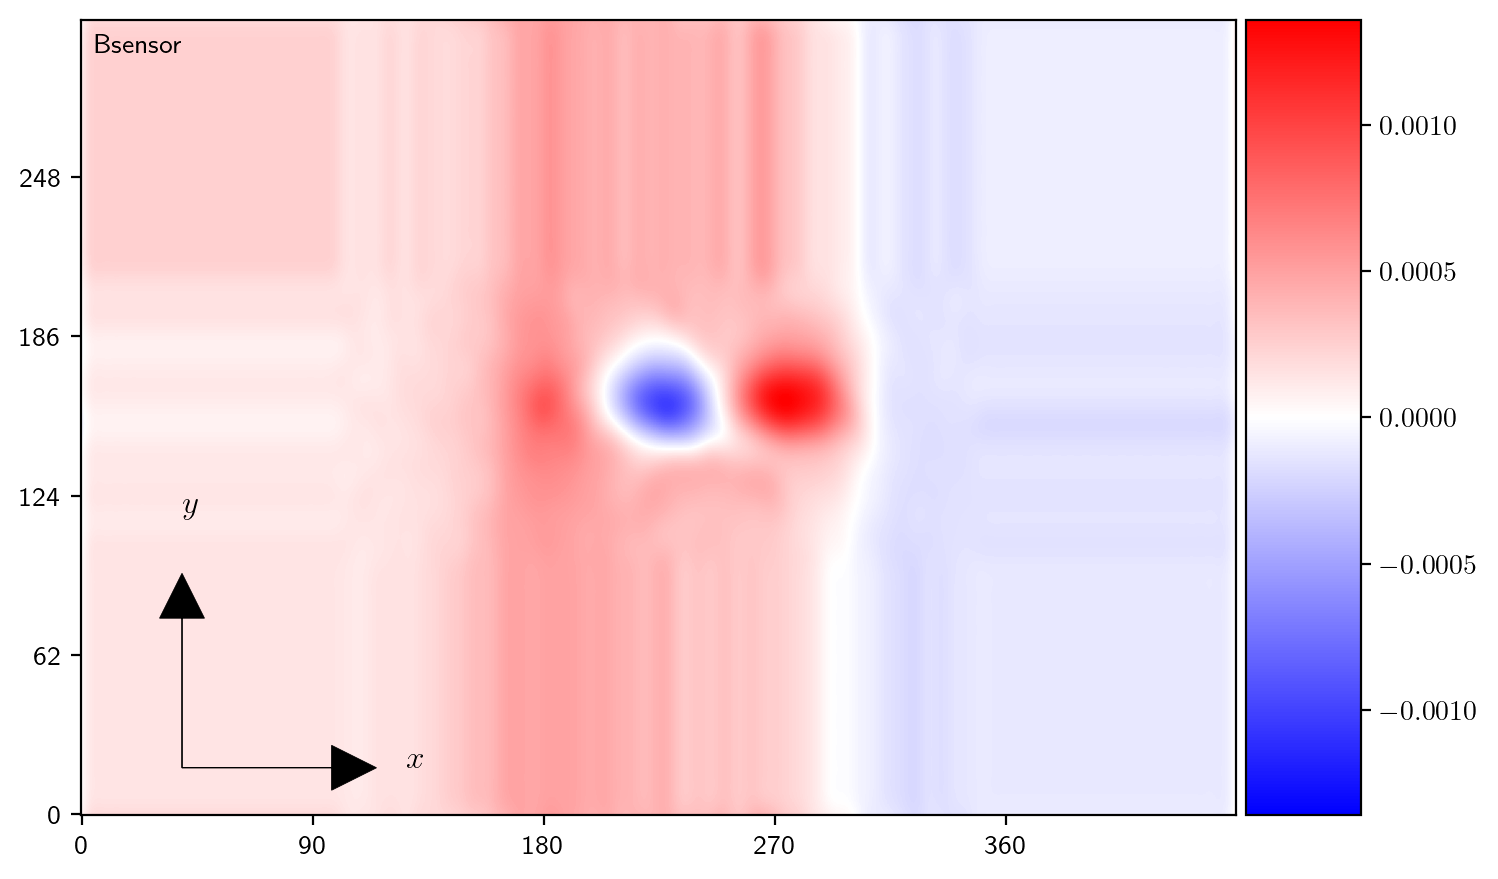

In [106]:

plot_n_components(
    dataset.target, 
    symmetric=True, 
    labels=["Bsensor"], 
    cmap="bwr")

## Reconstruct the current density using a neural network using Bz data

In [107]:
from magrec.method.FCNN import FCNN
from magrec.models.Jxy import Jxy



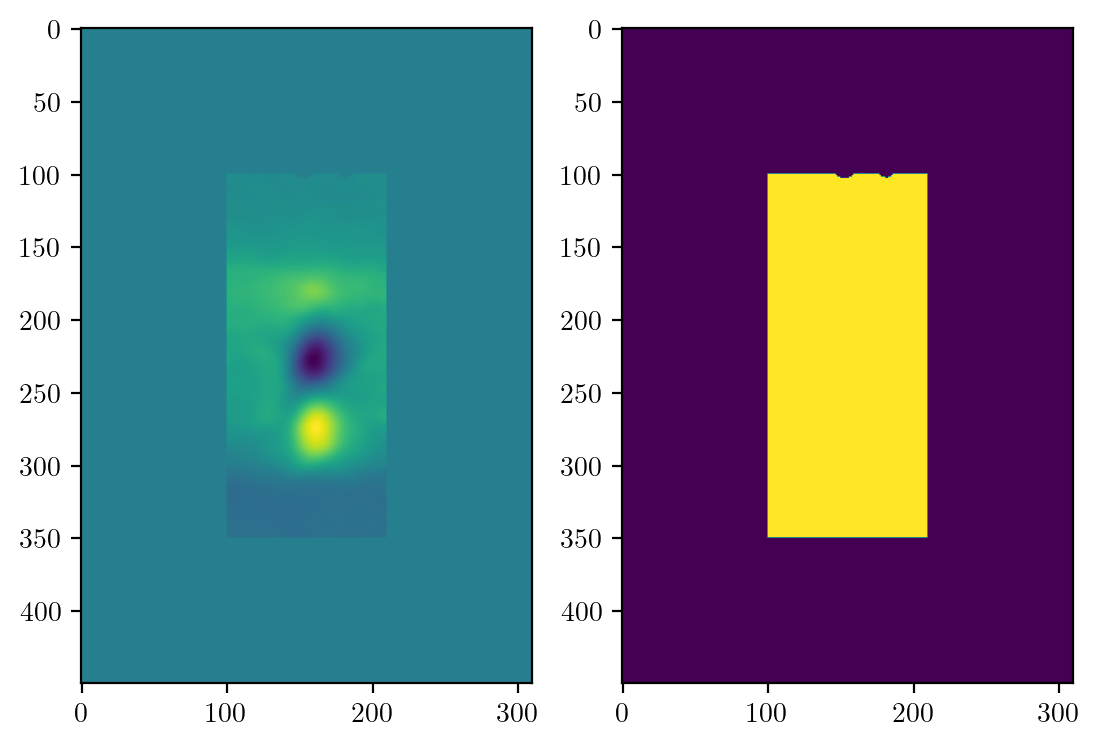

In [117]:
import magrec.image_processing.Masks as Masks
weight1 = Masks.mask_vert_dir(dataset.target, 1e-4,  plot=False)

# weight2 = Masks.mask_vert_dir(dataset2.target, 0.00001,  plot=True)
weight = weight1
weight[::,0:100] = 0 
weight[::,-100::] = 0 
weight[0:100,::] = 0 
weight[-100::,::] = 0 

plt.figure()
plt.subplot(1,2,1)
plt.imshow(dataset.target * weight)

plt.subplot(1,2,2)
plt.imshow(weight)


In [125]:
Model = Jxy(dataset, "MSE")
FittingMethod = FCNN(Model, dataset)
# FittingMethod.prepare_fit(loss_weight=weight)
FittingMethod.prepare_fit()

Number of sources: 2
Number of targets: 1


In [126]:
FittingMethod.fit(n_epochs=151)
# FittingMethod.fit(n_epochs=100)

epoch     1 | loss on last mini-batch:  7.38e+04
epoch    11 | loss on last mini-batch:  7.27e+04
epoch    21 | loss on last mini-batch:  3.07e+04


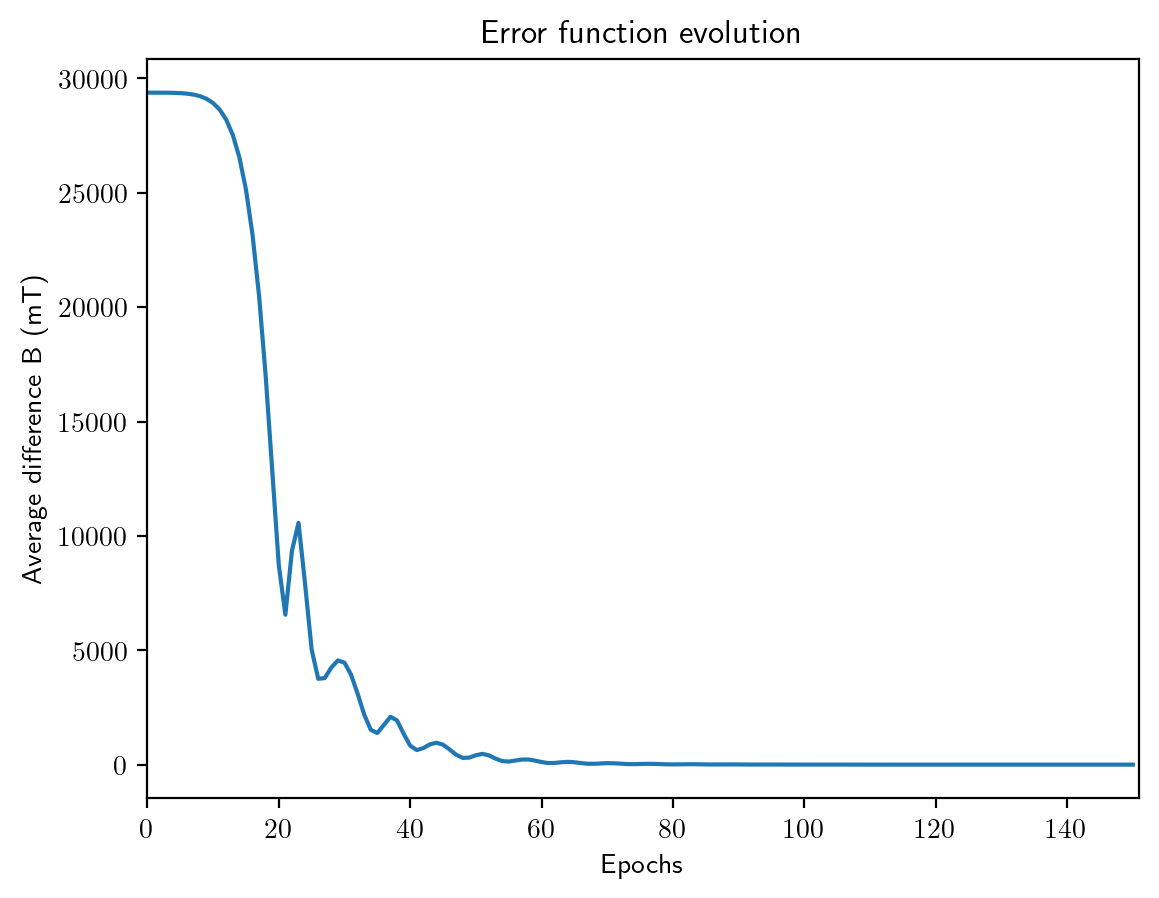

In [ ]:
FittingMethod.plot_loss()

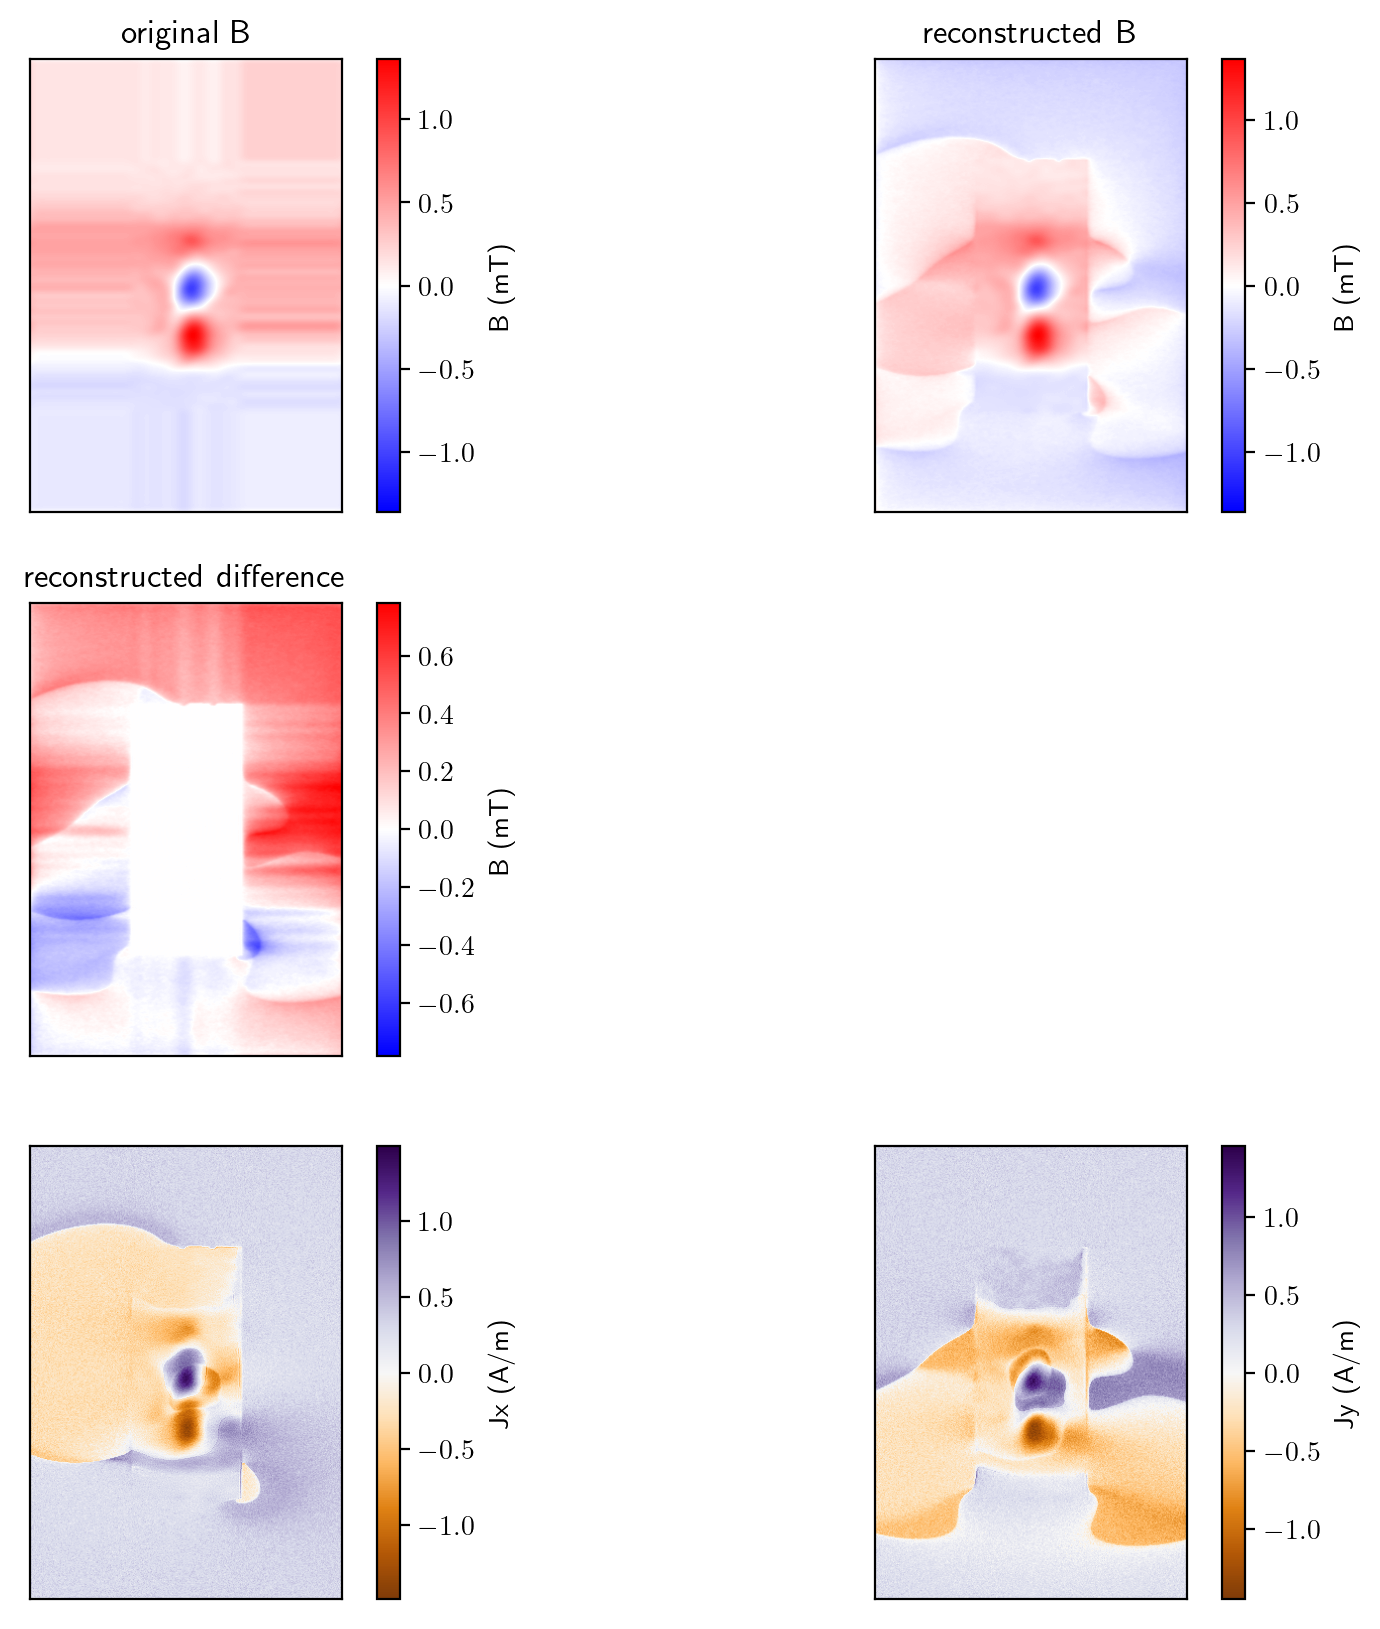

In [ ]:
FittingMethod.extract_results(remove_padding=False)
FittingMethod.plot_results()

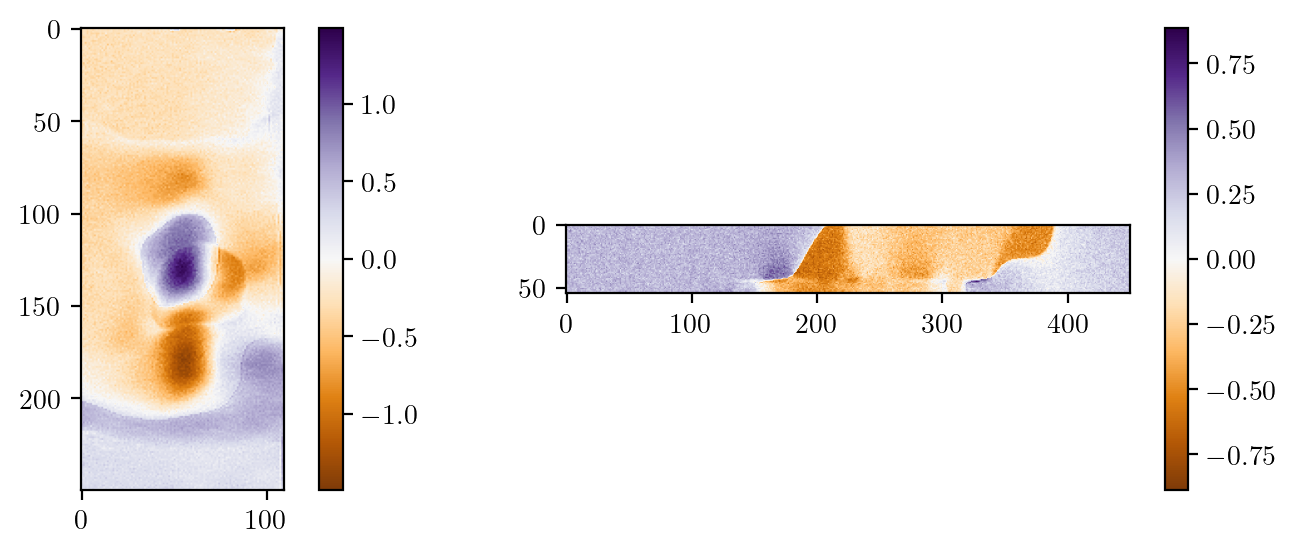

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 3)
plt.subplot(1,2,1)
plot_data = FittingMethod.model.results['Jx'][100:-100,100:-100]
plot_range = np.max(np.abs(plot_data.numpy()))
plt.imshow(plot_data, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()

plt.subplot(1,2,2)
plot_data = FittingMethod.model.results['Jy'][100:-100,100:-100]
plot_range = np.max(np.abs(plot_data.numpy()))
plt.imshow(plot_data, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()

[131, 381, 91, 421]
Number of sources: 2
Number of targets: 1


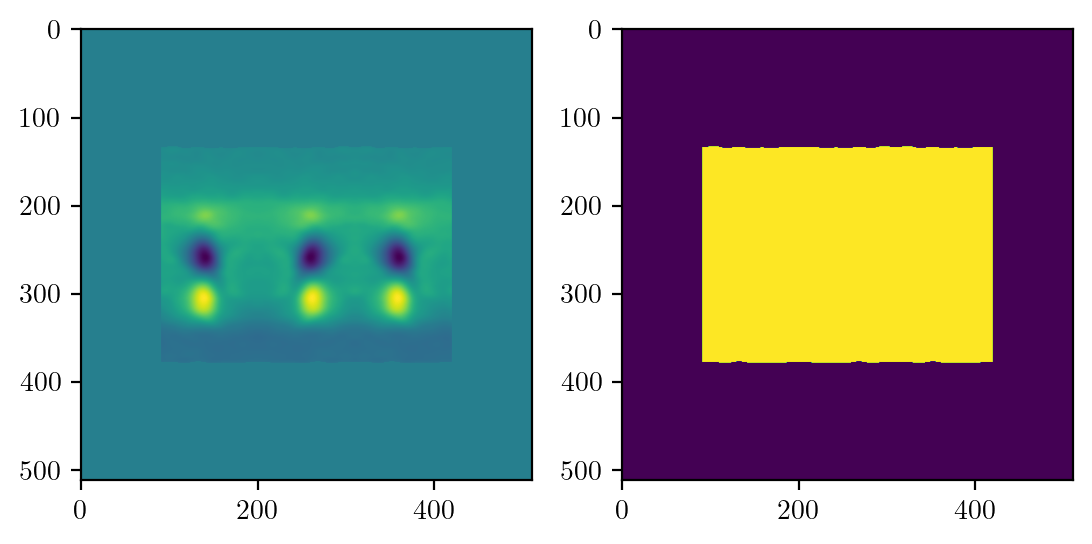

In [93]:
from magrec.method.CNN import CNN
from magrec.models.Jxy import Jxy

dataset3 = copy.deepcopy(dataset)

dataset3.pad_data_to_power_of_two()

import magrec.image_processing.Masks as Masks
weight1 = Masks.mask_vert_dir(dataset3.target, 1e-4,  plot=False)

# weight2 = Masks.mask_vert_dir(dataset2.target, 0.00001,  plot=True)
weight = weight1
# weight[::,0:85] = 0 
# weight[::,180::] = 0 

plt.figure()
plt.subplot(1,2,1)
plt.imshow(dataset3.target * weight)

plt.subplot(1,2,2)
plt.imshow(weight)



Model = Jxy(dataset3, "MSE")
FittingMethod = CNN(Model, dataset3)
FittingMethod.prepare_fit(loss_weight=weight)

C:\Users\parax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 512, 512])) that is different to the input size (torch.Size([1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch     1 | loss on last mini-batch:  6.12e+04
epoch    11 | loss on last mini-batch:  7.30e+03
epoch    21 | loss on last mini-batch:  4.76e+03
epoch    31 | loss on last mini-batch:  3.00e+03
epoch    41 | loss on last mini-batch:  9.41e+02
epoch    51 | loss on last mini-batch:  5.38e+02
epoch    61 | loss on last mini-batch:  4.35e+02
epoch    71 | loss on last mini-batch:  2.92e+02
epoch    81 | loss on last mini-batch:  2.56e+02
epoch    91 | loss on last mini-batch:  2.09e+02


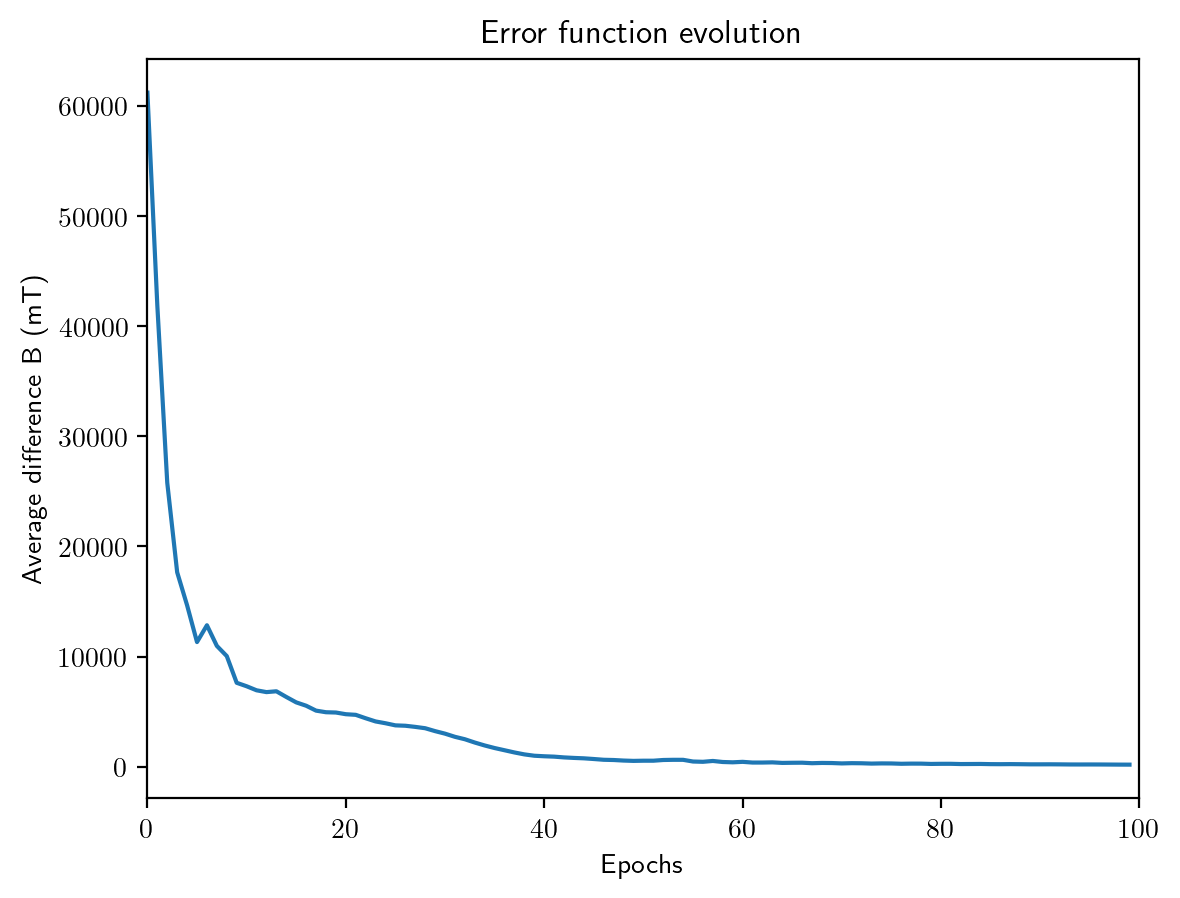

In [94]:
FittingMethod.fit(n_epochs=100, weight=weight)
FittingMethod.plot_loss()

Removed the padding that was applied to the data


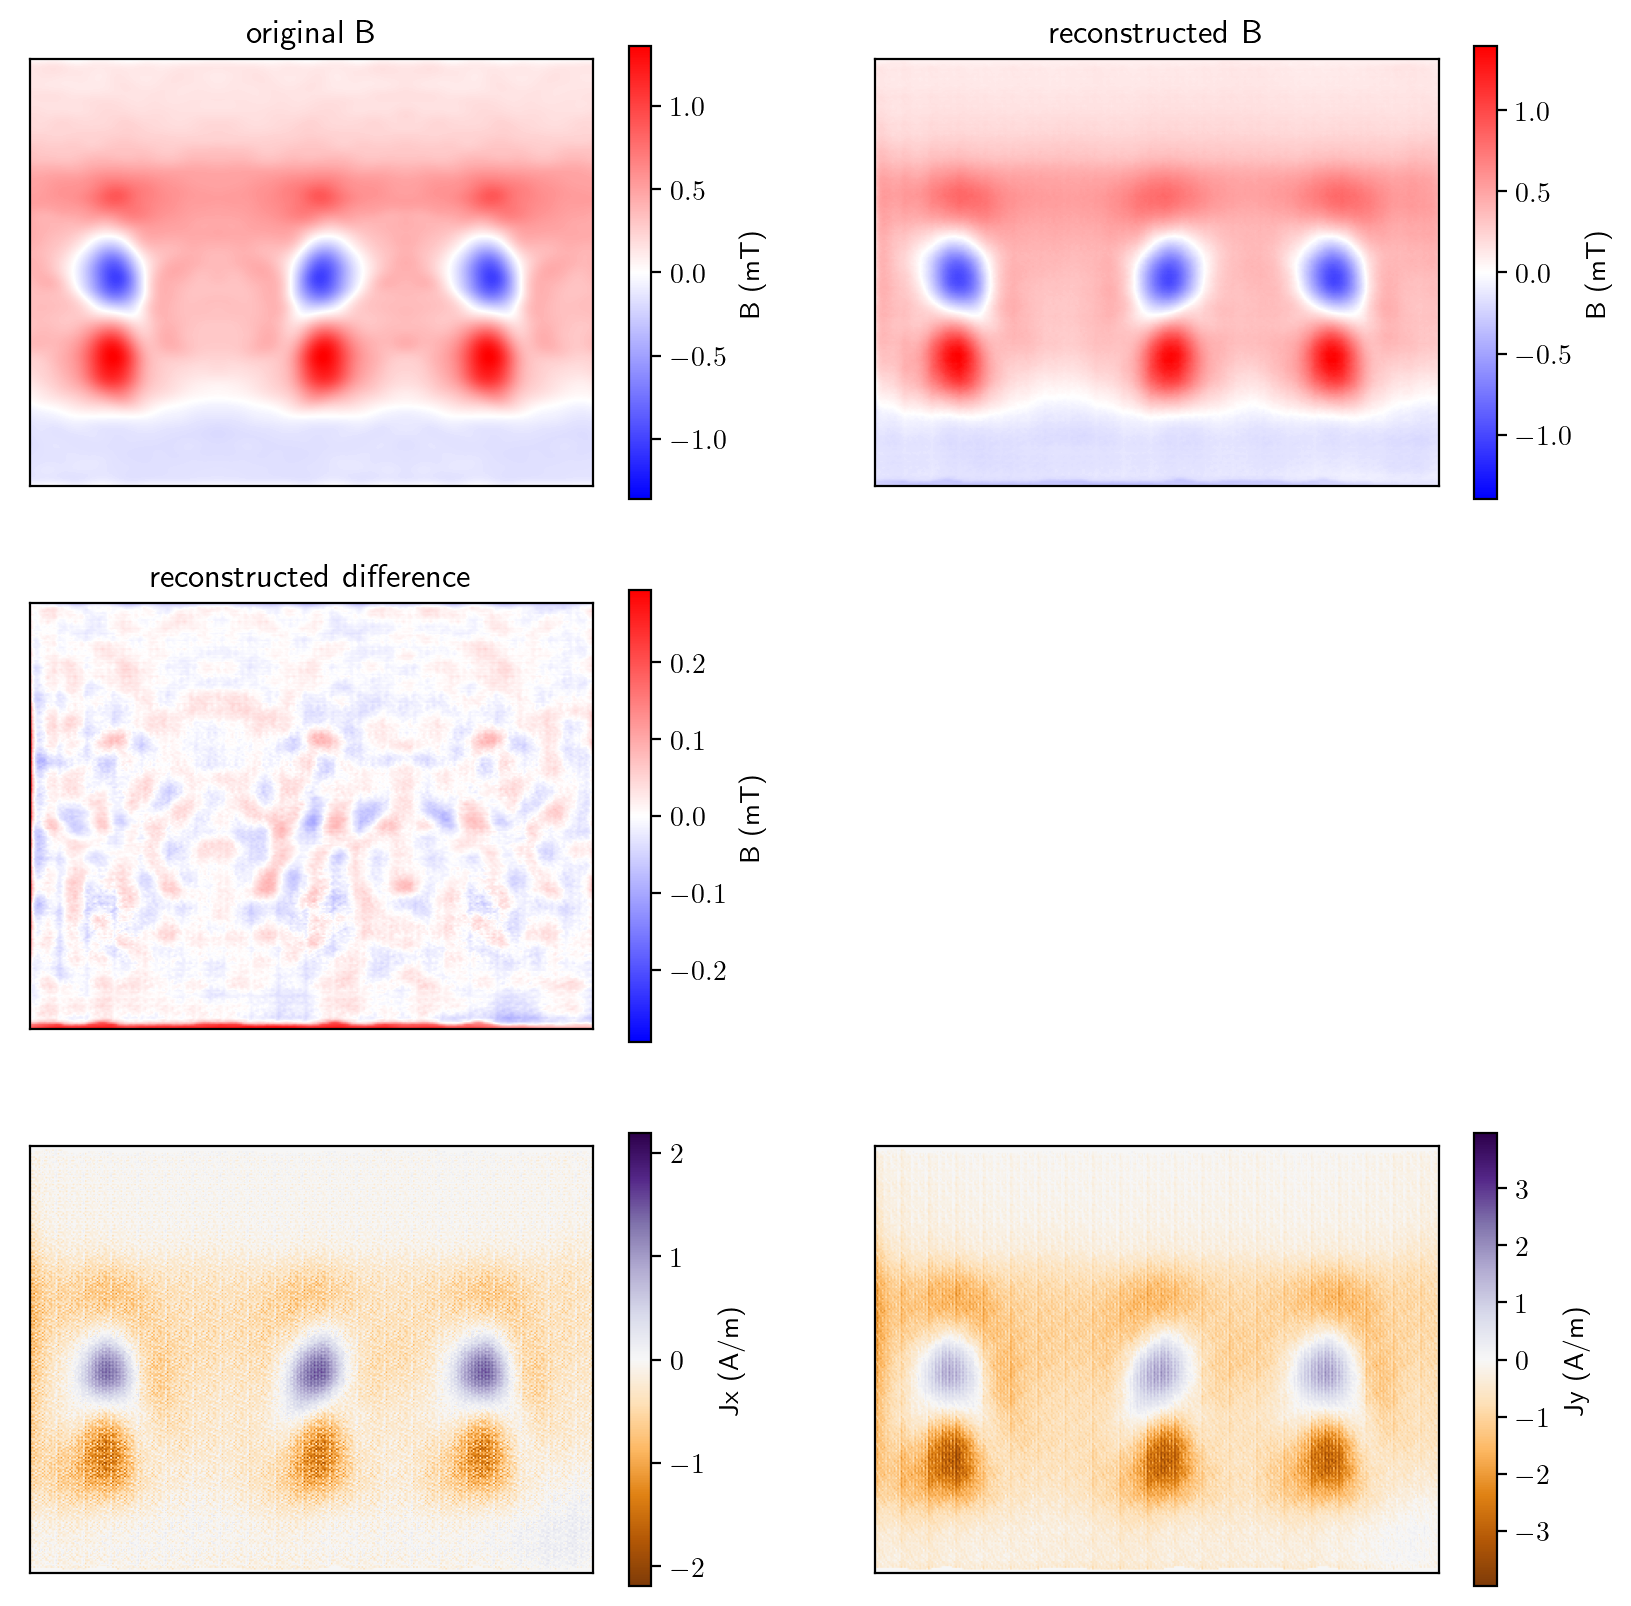

In [95]:
FittingMethod.extract_results(remove_padding=True)
FittingMethod.plot_results()